<a href="https://colab.research.google.com/github/Rajayogi/Indian-Food-Classification/blob/master/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install split-folders

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls "gdrive/My Drive/indian food dataset.zip"
!unzip -q "gdrive/My Drive/indian food dataset.zip"

'gdrive/My Drive/indian food dataset.zip'


In [0]:
import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio('indian food dataset', output="final", seed=1337, ratio=(.8, .2)) # default values

In [6]:
import os
import gc
import numpy as np 
import pandas as pd
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 as tmodel_vgg16
from keras.applications.xception import Xception 
from keras.applications.resnet50 import ResNet50 as resnet50
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,MaxPooling2D
from keras.models import Sequential, Model 
import datetime as dt

from keras.optimizers import SGD,Adam
from keras.layers import Input,SeparableConv2D,Conv2D
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras import backend as K
from keras.layers import MaxPool2D,concatenate
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.callbacks import EarlyStopping,CSVLogger,ReduceLROnPlateau,TensorBoard
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model

print(os.listdir("final"))
print("Models Loaded")

Using TensorFlow backend.


['train', 'val']
Models Loaded


In [7]:
batchsize=32
imgsize=150
height,width,channels=150,150,3
targetsize=(150,150)
inputshape=(150,150,3)
batch_size=32
seed=69
lr = Adam(lr=1e-3)
classes = 20
steps = 250
epochs = 30

print("Model Loaded")
print("HyperParameters Ready")

Instructions for updating:
Colocations handled automatically by placer.
Model Loaded
HyperParameters Ready


In [9]:
trn_dir = 'final/train'
val_dir = 'final/val'

classes = pd.read_csv("classes.txt")
food_classes = 20
classes

,'Biryani','Chapati','Chicken_curry','Curd Rice','Dosa','Fried Fish','Fried chicken','Fried rice','Idly','Omelette','Payasam','Pongal','Puliyogare','Puri','Ragi ball','Sambar','Samosa','Upma','White rice','salad'


In [10]:
trn_augs = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2)
            
val_augs = ImageDataGenerator(preprocessing_function=preprocess_input)

trn_gen = trn_augs.flow_from_directory(
       directory = trn_dir,
       target_size=(224,224),
       batch_size=32,
       class_mode='categorical')

val_gen = val_augs.flow_from_directory(
       directory = val_dir,
       target_size=(224,224),
       class_mode='categorical')
print("Augmentation Complete")

Found 7999 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.
Augmentation Complete


In [11]:
classes = 20
tmodel = Sequential()
tmodel.add(resnet50(include_top=False, pooling='avg', weights='imagenet'))
tmodel.add(Dropout(0.5))
tmodel.add(Dense(classes, activation='softmax',name='classifier'))

tmodel.layers[0].trainable = False
tmodel.summary()

94658560/94653016 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
classifier (Dense)           (None, 20)                40980     
Total params: 23,628,692
Trainable params: 40,980
Non-trainable params: 23,587,712
_________________________________________________________________


Complete


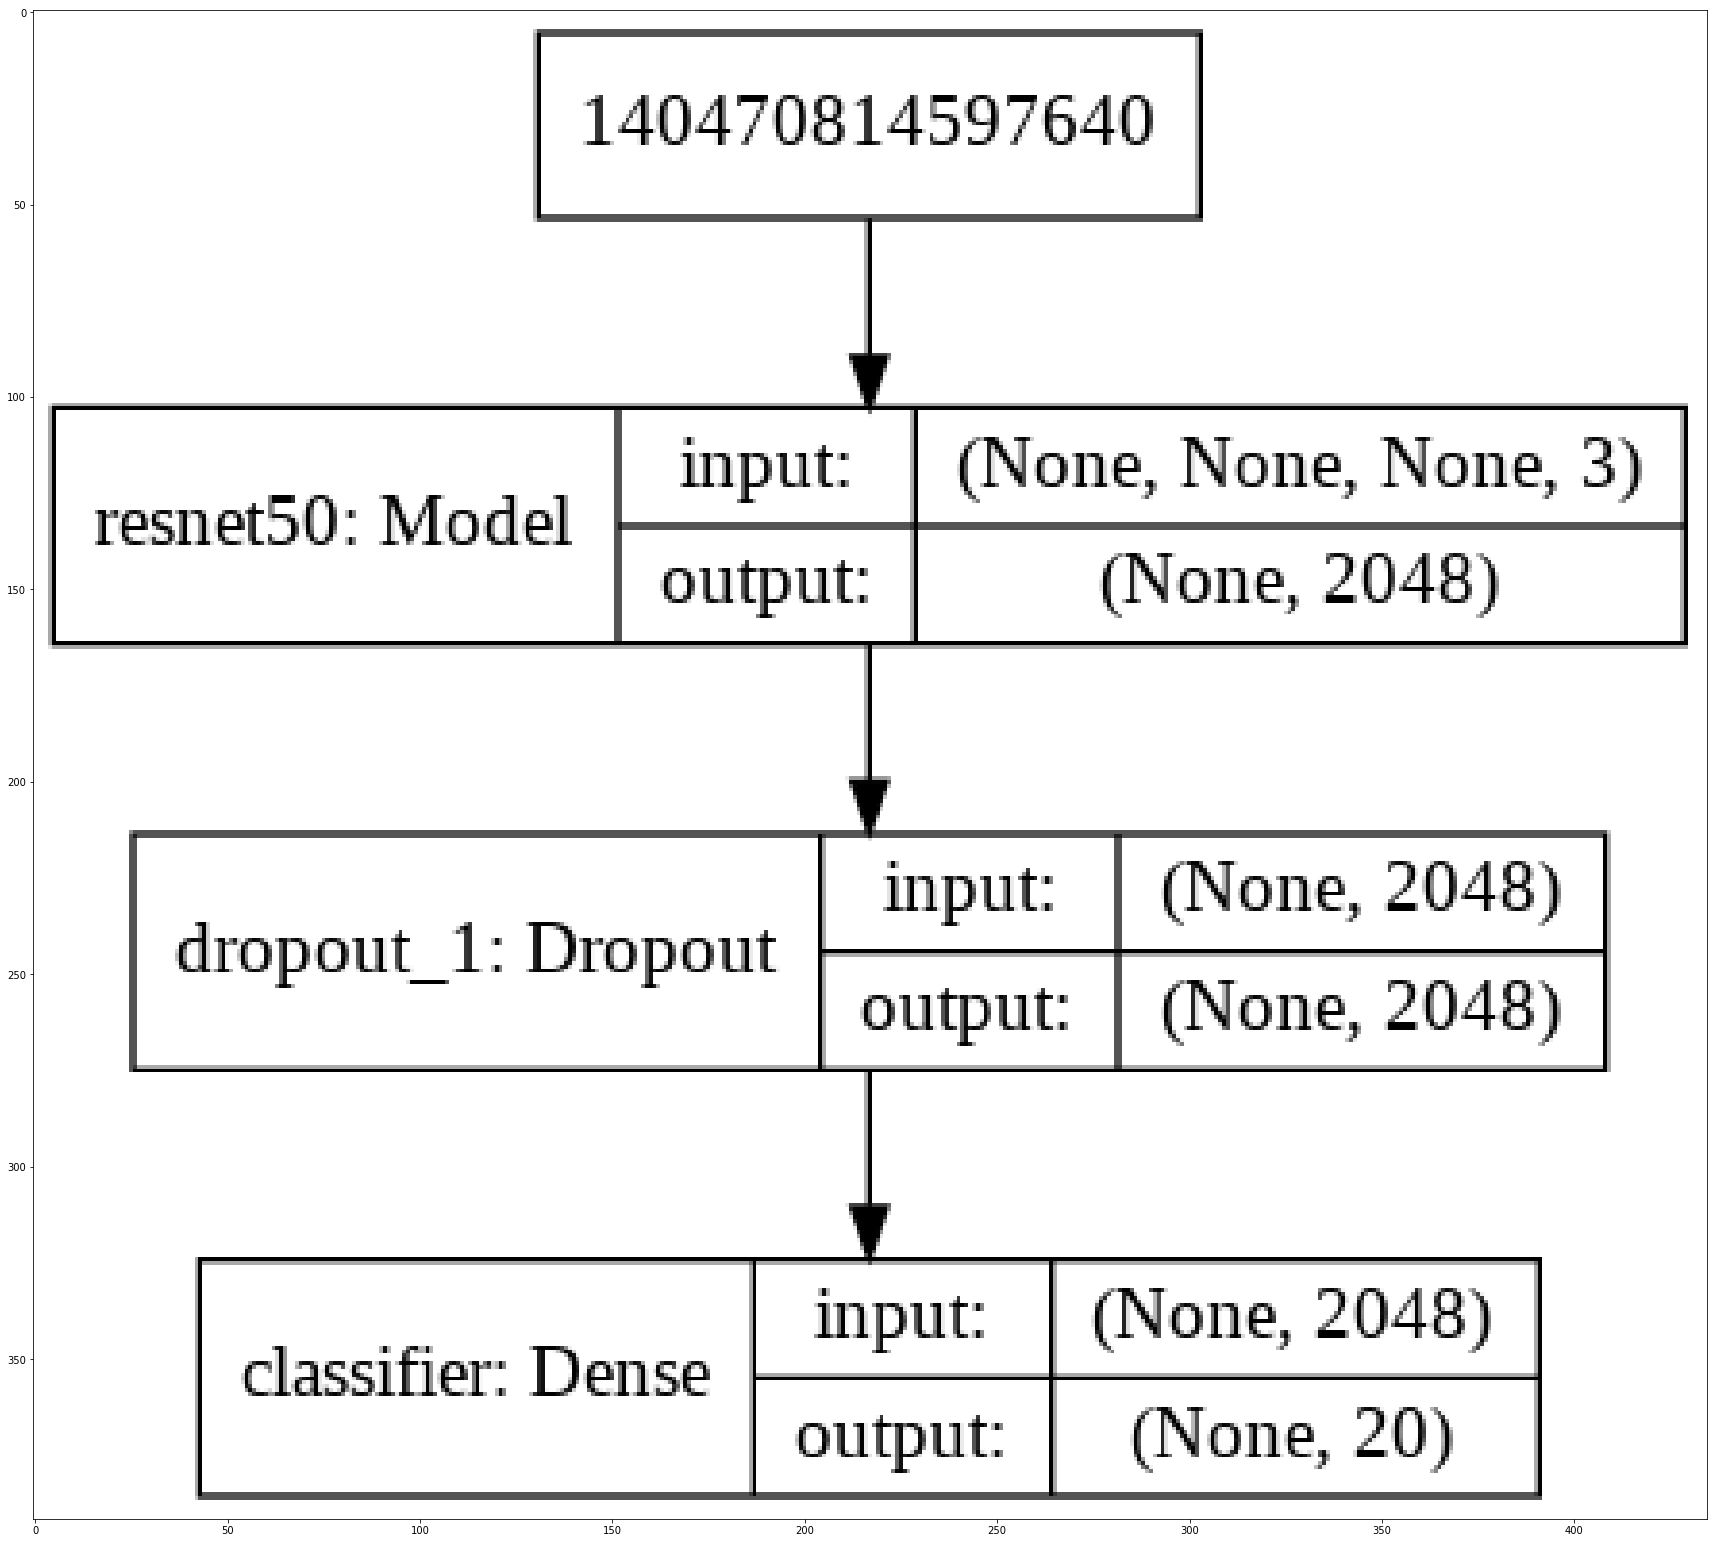

In [12]:
plot_model(tmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(30,30))
plt.imshow(plt.imread('model_plot.png'))
print("Complete")

In [13]:
opt = SGD(lr=1e-2,decay=0.0001,momentum=0.9)
tmodel.compile(
    metrics=['categorical_accuracy'],
    optimizer='sgd',
    loss='categorical_crossentropy'
)
print("Model Compiled Ready For Training")

Model Compiled Ready For Training


In [14]:
best_weights = "/tmp/weights.hdf5"
checkpoint = ModelCheckpoint(
    best_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=True,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=batchsize,
    write_graph=True,
    write_grads=True,
    write_images=False,
)
reducelr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=1e-3,
    min_lr=1e-3
)


callbacks = [checkpoint,earlystop,tensorboard]
print("CallBacks Ready!")


CallBacks Ready!


In [15]:
history = tmodel.fit_generator(
    trn_gen,
    steps_per_epoch=250,
    epochs=30,
    verbose=1,
    validation_data=val_gen,
    validation_steps=60,
    callbacks=callbacks
)
print("Model Trained")

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
250/250 [==============================] - 111s 445ms/step - loss: 2.2681 - categorical_accuracy: 0.3287 - val_loss: 1.3587 - val_categorical_accuracy: 0.6005

Epoch 00001: val_loss improved from inf to 1.35867, saving model to /tmp/weights.hdf5
Epoch 2/30
250/250 [==============================] - 103s 413ms/step - loss: 1.4332 - categorical_accuracy: 0.5637 - val_loss: 1.2653 - val_categorical_accuracy: 0.6145

Epoch 00002: val_loss improved from 1.35867 to 1.26528, saving model to /tmp/weights.hdf5
Epoch 3/30
250/250 [==============================] - 103s 411ms/step - loss: 1.2293 - categorical_accuracy: 0.6307 - val_loss: 1.1796 - val_categorical_accuracy: 0.6439

Epoch 00003: val_loss improved from 1.26528 to 1.17959, saving model to /tmp/weights.hdf5
Epoch 4/30
250/250 [==============================] - 102s 409ms/step - loss: 1.1173 - categorical_accuracy: 0.6591 - val_loss: 1.2133 - val_categorical_accuracy: 0.6455

Ep